# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

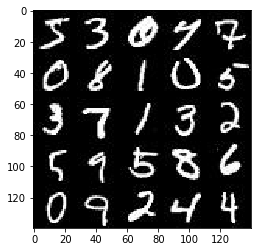

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

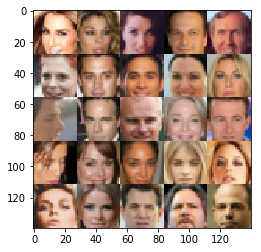

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
    
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_num = 0
    samples, losses = [], []
    
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                                # Sample random noise for G
                
                # Scale images between -1 and 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                batch_num += 1
                
                if (batch_num%100 == 0):
                    show_generator_output(sess=sess,
                                          image_mode=data_image_mode,
                                          input_z=input_z,
                                          n_images=10,
                                          out_channel_dim=image_channels)
            
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

            saver.save(sess, './trainSaver/generator.ckpt')
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 4.6589... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 3.8629
Epoch 1/2... Discriminator Loss: 4.2636... Generator Loss: 0.4024
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 4.2777
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 2.6594
Epoch 1/2... Discriminator Loss: 4.7807... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 3.0989... Generator Loss: 8.6483
Epoch 1/2... Discriminator Loss: 4.4875... Generator Loss: 0.4295
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 6.4639
Epoch 1/2... Discriminator Loss: 1.8950... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.6503... Generator Loss: 2.7921
Epoch 1/2... Discriminator Loss: 6.4421... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 2.2808... Generator Loss: 4.0713
Epoch 1/2... Discriminator Loss: 3.1125... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 2.3055
Epoch 1/2.

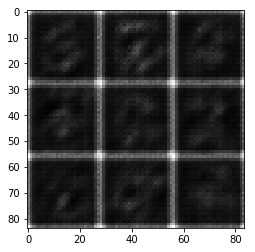

Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.5610... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.8757... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 1.6375... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.8080... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 1.6356... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.5933... Generator Loss: 0.5722
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.6659
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.6118
Epoch 1/2.

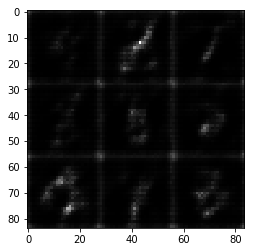

Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 0.4400
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 1.4642
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.5802
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 1.6000... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.3012
Epoch 1/2.

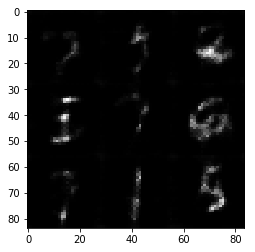

Epoch 1/2... Discriminator Loss: 1.7682... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 1.4746
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 1.6359
Epoch 1/2.

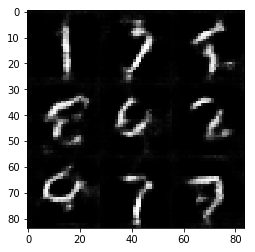

Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.4395
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.6189... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 1.8887... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 1.4367
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 1.6900... Generator Loss: 0.4747
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.1676
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.7897
Epoch 1/2.

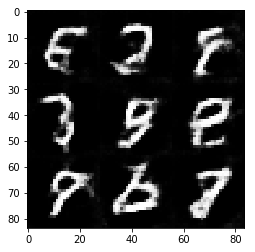

Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.2249
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.8154
Epoch 1/2.

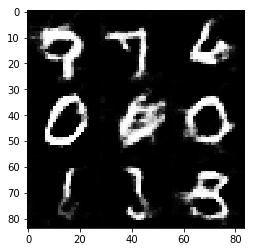

Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.4971... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.1058
Epoch 1/2... Discriminator Loss: 1.2024... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.7173
Epoch 1/2.

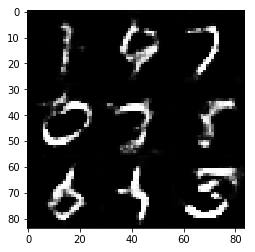

Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 1.0737
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.8684
Epoch 1/2.

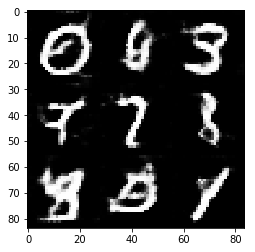

Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.9453
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.2874
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 0.8299
Epoch 1/2.

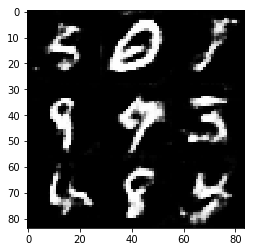

Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.8236... Generator Loss: 2.1903
Epoch 1/2... Discriminator Loss: 2.3249... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.8178
Epoch 1/2.

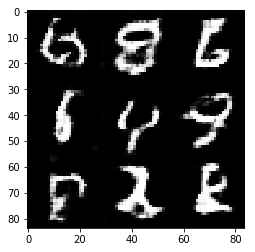

Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 0.9093... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 1.4896
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.8307
Epoch 1/2.

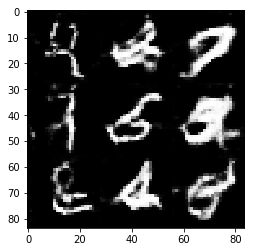

Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.8535
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 1.2602
Epoch 1/2... Discriminator Loss: 1.7543... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 1.6278
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.0390
Epoch 1/2.

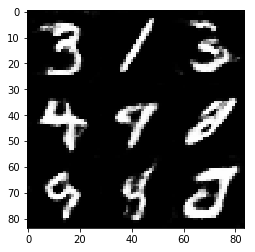

Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.4667
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.3271
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.6411
Epoch 1/2... Discriminator Loss: 1.9750... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 3.5724... Generator Loss: 4.1861
Epoch 1/2.

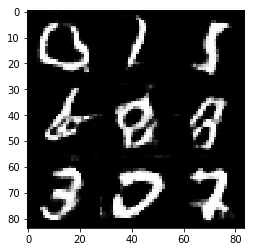

Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 2.7154
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 0.7654
Epoch 1/2.

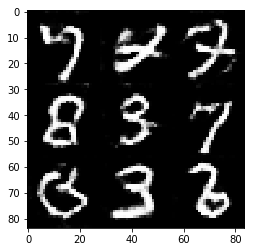

Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.2229
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 0.9935
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 0.8231... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.7878... Generator Loss: 1.0904
Epoch 1/2.

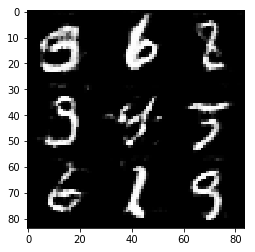

Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.7238
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 0.6959... Generator Loss: 1.4132
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 1.2240
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 1.7563... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 1.9533
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.9058
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 1.5061
Epoch 1/2.

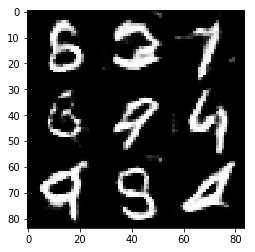

Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.6796
Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.9737
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 1.5689
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 1.3975
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.2475
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.5472
Epoch 1/2.

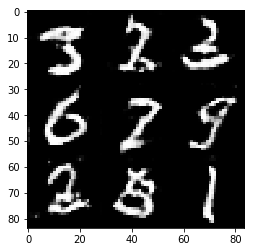

Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.2380
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 2.4921
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 1.4196
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 1.8438
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 0.6596... Generator Loss: 1.4042
Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 1.5806
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.7127... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 2.1938
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.7059
Epoch 1/2.

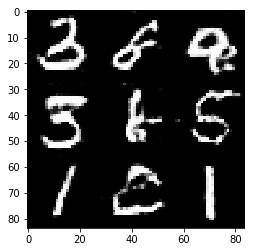

Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 2.5205
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.0617
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.8631... Generator Loss: 3.0055
Epoch 1/2... Discriminator Loss: 2.1315... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 2.8656
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.5370
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.1038
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 1.2893
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.8574
Epoch 1/2.

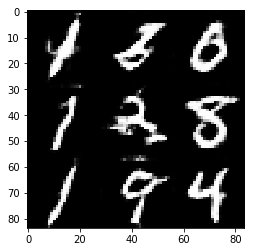

Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.8610
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.3244
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.0557
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.0952
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.0841
Epoch 2/2.

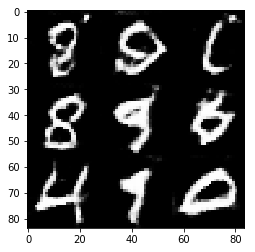

Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 2.1097
Epoch 2/2... Discriminator Loss: 1.4584... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.1726
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 1.1392
Epoch 2/2.

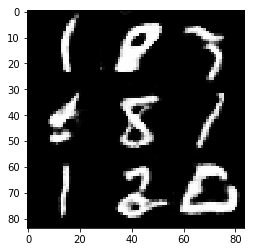

Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.4078
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 0.7536
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.7045... Generator Loss: 1.3858
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 1.6401... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.8863
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 1.9923
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.5992
Epoch 2/2.

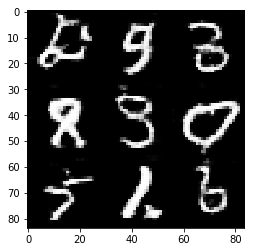

Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.6702
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.4601
Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.1788
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.5520
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.0373
Epoch 2/2.

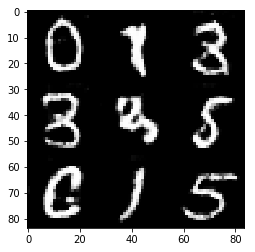

Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.6171
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.9089
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 2.0265
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 2.1512
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.2296
Epoch 2/2.

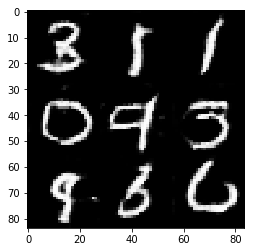

Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.6455
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.3038
Epoch 2/2... Discriminator Loss: 2.2548... Generator Loss: 0.3741
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 2.3058
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.7576
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 2.3282
Epoch 2/2... Discriminator Loss: 1.9094... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 2.7934... Generator Loss: 5.0493
Epoch 2/2... Discriminator Loss: 3.1445... Generator Loss: 0.5090
Epoch 2/2.

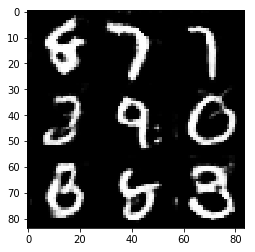

Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.9166
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.3871
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.1961
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.5505
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.0869
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.3383
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.1466
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.9958
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.3132
Epoch 2/2.

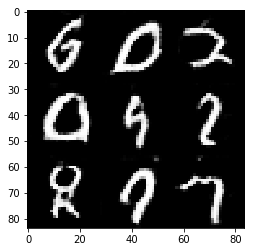

Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.4183
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.6177
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 0.6594... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.6483
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.3745
Epoch 2/2... Discriminator Loss: 1.5452... Generator Loss: 0.5126
Epoch 2/2.

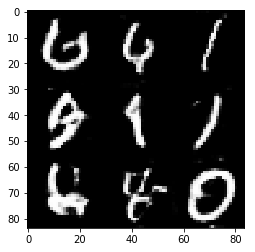

Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.4710
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 1.5475... Generator Loss: 0.5041
Epoch 2/2... Discriminator Loss: 0.6897... Generator Loss: 2.0423
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.5581
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.8461
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.5843
Epoch 2/2... Discriminator Loss: 1.8185... Generator Loss: 0.5027
Epoch 2/2... Discriminator Loss: 2.2843... Generator Loss: 3.5942
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.9337
Epoch 2/2.

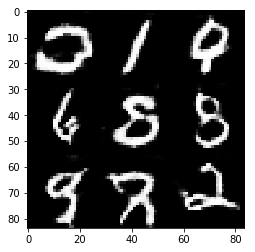

Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 2.9954
Epoch 2/2... Discriminator Loss: 1.5438... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 1.9384
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 2.3030
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 1.8956
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.9427
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.9735
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.4054
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.9668
Epoch 2/2.

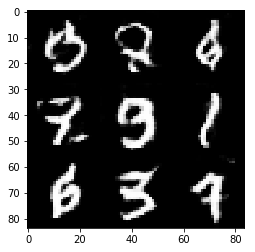

Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.9395
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.1367
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.6860
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.6723
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.1501
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 1.8555
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 1.9797
Epoch 2/2... Discriminator Loss: 0.7513... Generator Loss: 1.2198
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.9149
Epoch 2/2.

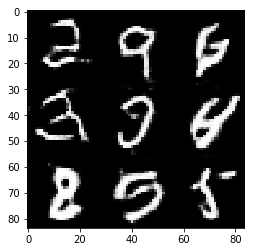

Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.8236
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.6627
Epoch 2/2... Discriminator Loss: 2.0342... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.8146
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 3.0983
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 2.0386
Epoch 2/2... Discriminator Loss: 1.7986... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 2.2984
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 0.8068... Generator Loss: 1.3852
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.6461
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 0.9198
Epoch 2/2.

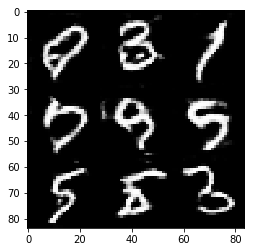

Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.6905
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.3807
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 2.2525
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 1.8699
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.1169
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.3719
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 1.3096
Epoch 2/2.

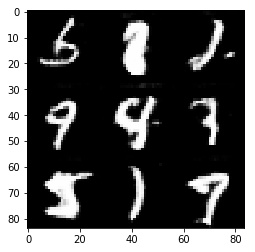

Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.4739
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.6126
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.0730
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 1.3413
Epoch 2/2.

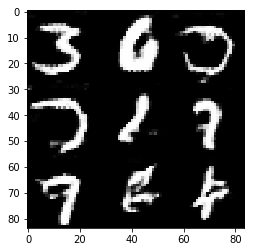

Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.8021
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.8023
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.5198
Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.8735
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.7064
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.5173... Generator Loss: 2.1217
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 1.6867
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9309
Epoch 2/2.

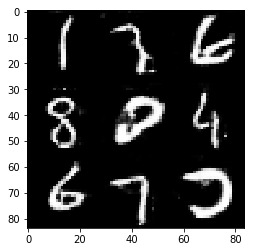

Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.4194
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 2.4429
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 2.2861
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 3.2833
Epoch 2/2... Discriminator Loss: 0.6730... Generator Loss: 1.6587
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.7077
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.1313
Epoch 2/2.

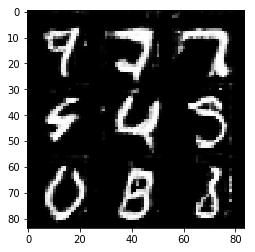

Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 2.3059
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.0476
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.5110
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.2079
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 2.3270
Epoch 2/2... Discriminator Loss: 1.9299... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 2.6269
Epoch 2/2... Discriminator Loss: 2.9628... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 3.1108
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.6115
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.2073
Epoch 2/2.

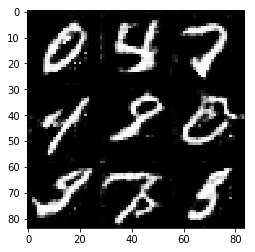

Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.4132
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.5373
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 0.6533... Generator Loss: 1.4793
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 2.0624
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 2.6568
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.6323
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.7640
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.8687
Epoch 2/2.

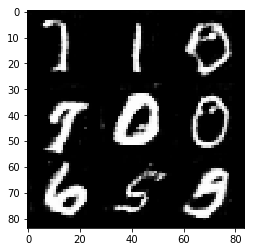

Epoch 2/2... Discriminator Loss: 2.4034... Generator Loss: 3.8525
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.5774
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 2.5689
Epoch 2/2... Discriminator Loss: 2.0884... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.5558... Generator Loss: 3.5999
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 2.1283
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.9321
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.9767
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.8361
Epoch 2/2.

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 3.3224... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.9881... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 1.8676... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.7788
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 2.0383
Epoch 1/1.

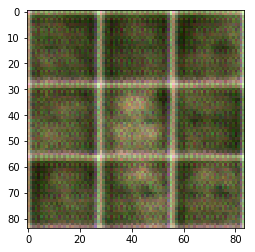

Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 4.1817
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 2.5578
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 2.1995
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.8763
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.4162
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 2.2093... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 5.3694
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6939
Epoch 1/1.

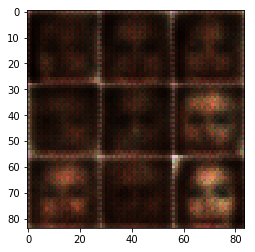

Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 4.4811
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.7897
Epoch 1/1... Discriminator Loss: 2.0216... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 2.7507
Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8975
Epoch 1/1.

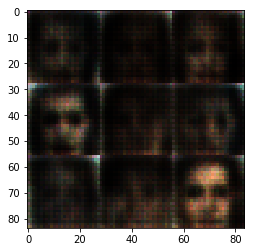

Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 2.1810
Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.2108
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.7645
Epoch 1/1... Discriminator Loss: 1.9546... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 4.2093
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 1.8966
Epoch 1/1... Discriminator Loss: 1.9411... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 3.7828
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.9013
Epoch 1/1.

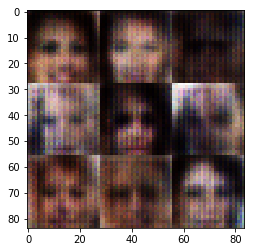

Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.5490
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 2.0449
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.5214
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 1.8537
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 2.2751
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 1.9240
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 3.6038
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.9574
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.8066
Epoch 1/1.

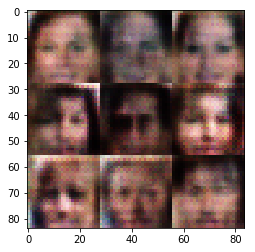

Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 5.4567
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.9952... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 3.3893
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.7854
Epoch 1/1... Discriminator Loss: 1.9469... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 3.1875
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.4958
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.2196
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.4363
Epoch 1/1.

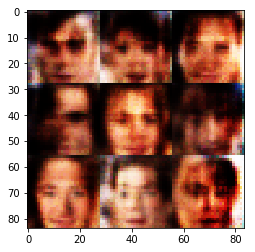

Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.7180
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.9744
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.3196
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 5.8553
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 5.2579
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.0680
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 3.6958
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 2.8244
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.9628
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 3.1247
Epoch 1/1.

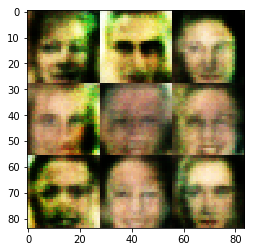

Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.9531
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 2.8256
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.2039
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 2.8322
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 2.9598... Generator Loss: 2.9762
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 2.3924... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7022
Epoch 1/1.

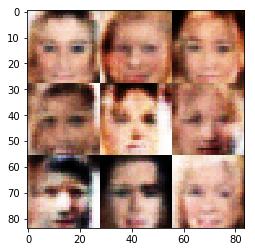

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 4.1242
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.4227
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 4.1688
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 5.0643
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.2932
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.5657
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.3582
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.4901
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.5928
Epoch 1/1.

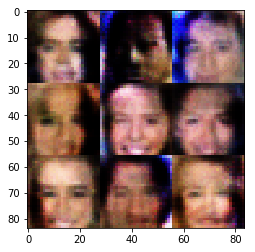

Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 5.4711
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.0069
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 2.5035
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.8227
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 2.8812
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 3.5016
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 4.5194
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.5060
Epoch 1/1.

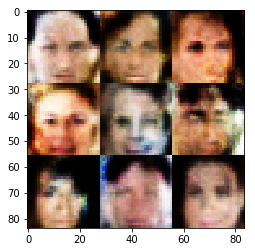

Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 4.5729
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.3896
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 3.3728
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 3.0007
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.8585
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 4.3703
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.9410
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.2904
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.7718
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.2035
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.8485
Epoch 1/1.

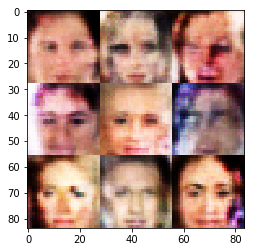

Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 4.7384
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.4614
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 3.7275
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 3.8893
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.1730
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 2.4491
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 4.3534
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 2.3706
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 2.8297
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.1277
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 2.8764
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.7603
Epoch 1/1.

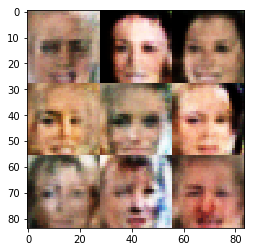

Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 3.4813
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 2.4185
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 3.5227
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 3.3825
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.7928
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 2.6277
Epoch 1/1... Discriminator Loss: 0.4303... Generator Loss: 2.4685
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 3.7684
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 2.5315
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.9375
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 3.7103
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 1.8582
Epoch 1/1.

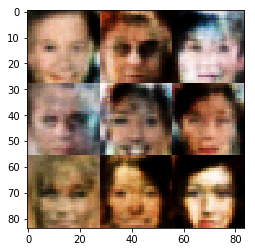

Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 2.2119
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 6.5320
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 3.1722
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 2.4638
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.2102
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 5.0546
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.3265
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 2.6365
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 4.1579
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 3.2007
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 3.4900
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 2.9423
Epoch 1/1.

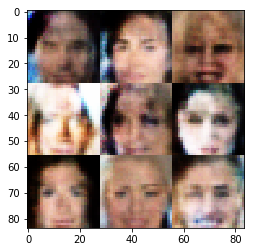

Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 5.2527
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.3930
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 5.4146
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.5255
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 3.5605
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 4.3626
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 2.8250
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 6.0789
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 3.2595
Epoch 1/1.

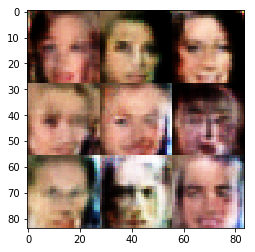

Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 2.2949
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 3.8841
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 4.1174
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 2.3632
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 3.9009
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 3.8399
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.6323
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.6580
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3933
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 6.4081
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 5.6096
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.9094
Epoch 1/1.

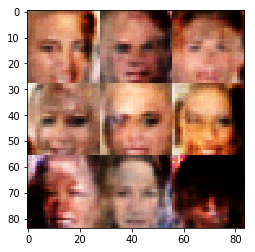

Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 2.4736
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 5.0303
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.0037
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 1.7293
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.9682
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 3.6566
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 2.6612
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 4.8885
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.0652
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 2.7059
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.5842
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.1452
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.0728
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 4.5975
Epoch 1/1.

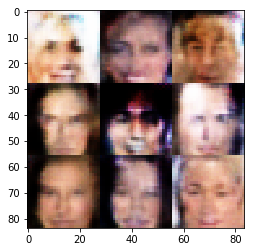

Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 1.9840
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 3.8462
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 4.0760
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 3.1268
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 2.8588
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 5.7905
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.3800
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 3.9536
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 3.2352
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.5706
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.3990
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.9552
Epoch 1/1.

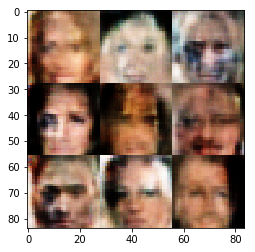

Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 2.2460
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 3.2089
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 3.3077
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.1293
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.0958
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 2.3020
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 2.6796
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 2.3780
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.6588
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 5.1584
Epoch 1/1.

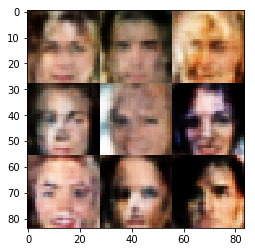

Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.4373
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 3.3539
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 4.7412
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.5117
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 4.4767
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.1198
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 3.5176
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 3.0136
Epoch 1/1... Discriminator Loss: 2.5371... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 3.6116... Generator Loss: 5.0475
Epoch 1/1... Discriminator Loss: 2.2494... Generator Loss: 0.4175
Epoch 1/1.

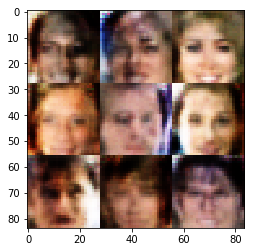

Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 4.4939
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.4051
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.1013
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 2.0091
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.0151
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 2.7583
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.1567
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.3031
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.0471
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.2223
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 3.5052
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.3305
Epoch 1/1.

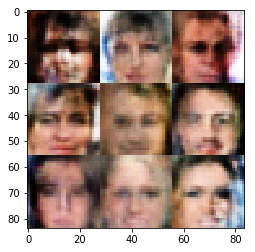

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 2.1505... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 2.0424
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 2.0033
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.7643
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.5552
Epoch 1/1.

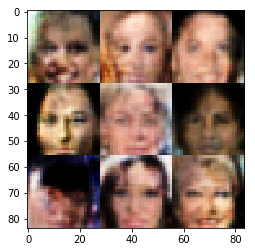

Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 3.4318
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.6499... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 3.5820
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 3.2610
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.9693
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.3420
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 4.7754
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 4.5744
Epoch 1/1.

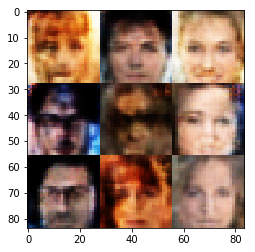

Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.9537
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 2.5060
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.0768
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.9007
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.8483
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.8082
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.9407
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.9203
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 3.3801
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 4.4708
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 2.5782
Epoch 1/1.

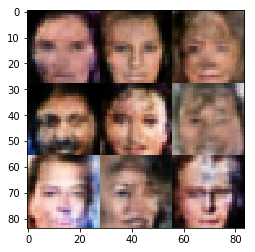

Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.6702
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.3269
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.3543
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.1719
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.3703
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 2.3556
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.1279
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.6058
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.5923
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.3503
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.1202
Epoch 1/1.

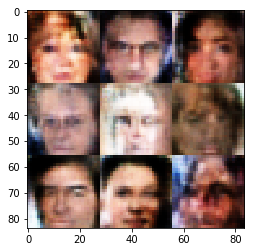

Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.8381
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.9833
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.4968
Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 3.0008
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.5465
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 2.6152
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.2406
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.2229
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.1267
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.1638
Epoch 1/1.

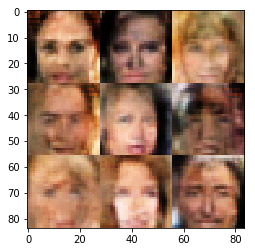

Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 1.9152
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.3027
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 3.0931
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 1.7520
Epoch 1/1.

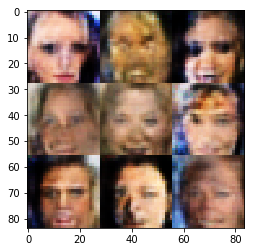

Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.9281
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.1515
Epoch 1/1.

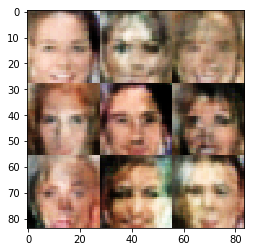

Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.0012
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 2.7895
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.1643
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.3738
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.3629
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 3.9488
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.1341
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.6691
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 4.6178
Epoch 1/1.

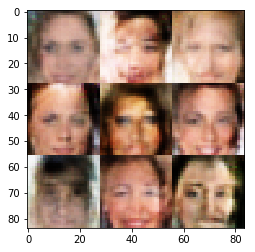

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 1.8955... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.4945
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 5.0295
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.2772
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.4446
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 1.5436
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 2.8887
Epoch 1/1.

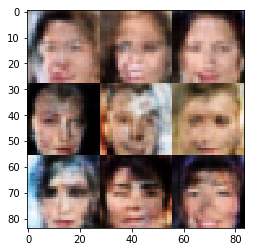

Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 2.6537
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.0454
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 2.9420
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.0947
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 2.7406
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.8460
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.3426
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.1600
Epoch 1/1.

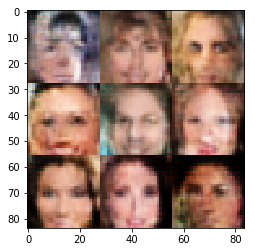

Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 4.2040
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 3.3311
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 3.0879
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 2.6624
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 3.2346
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.7242
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.4420
Epoch 1/1.

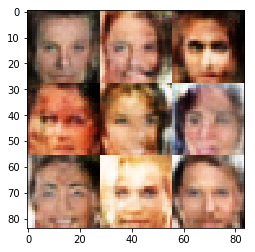

Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 3.2307
Epoch 1/1... Discriminator Loss: 2.8693... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 4.6659... Generator Loss: 6.9862
Epoch 1/1... Discriminator Loss: 2.5188... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 2.0133... Generator Loss: 3.5597
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 2.0564
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 2.0772
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.8489
Epoch 1/1.

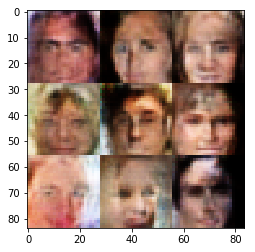

Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.9482
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 2.8503
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 2.7330
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.2388
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.3341
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.1693
Epoch 1/1.

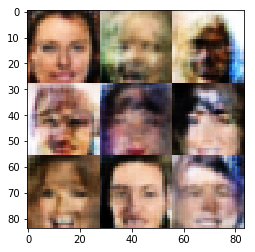

Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 2.1148
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.2167
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 2.3526
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 2.2678
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 1.9624
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.1335
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 2.8130
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 3.0448
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 2.6792
Epoch 1/1.

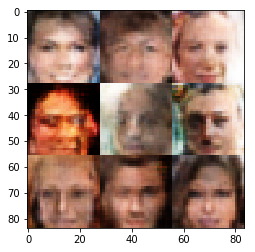

Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.1700
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 2.7980
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 5.8948
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 4.2001
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.9560
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.1695
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 2.0270
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 1.8722
Epoch 1/1.

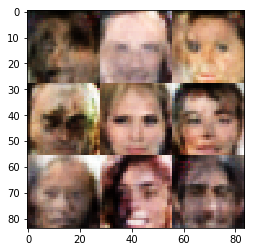

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 3.3520
Epoch 1/1... Discriminator Loss: 2.1651... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 2.6481
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.2986
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 3.1398
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.5776
Epoch 1/1.

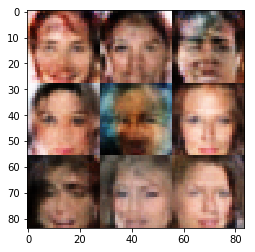

Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 3.6798
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 3.5341
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.6447
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.8384
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 2.3260
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.4352
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.9007
Epoch 1/1.

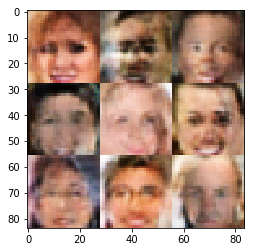

Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 1.9537
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.5857
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.5036
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.0814
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 2.0493
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.5106
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.4851
Epoch 1/1.

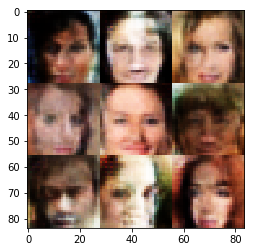

Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.5912
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.6172
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 4.2247
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 2.0827
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.6025
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 3.4255
Epoch 1/1.

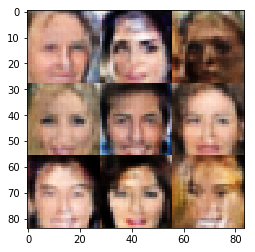

Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 2.8282
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.9705
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.1796
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 1.6140
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.6121
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.2575
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 4.8457
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.2190
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.5958
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.1713
Epoch 1/1.

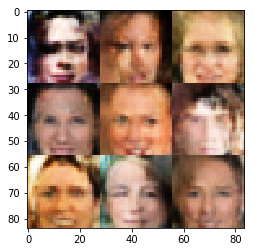

Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.9563
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 2.1070
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.4829
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 3.5467
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.1104
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6853
Epoch 1/1.

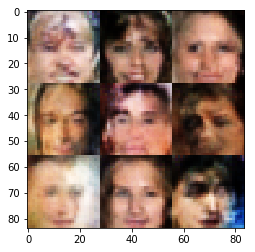

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 2.0847... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 2.5527... Generator Loss: 4.1064
Epoch 1/1... Discriminator Loss: 1.9205... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 2.7003
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 3.0756
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 2.5998
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.0526
Epoch 1/1.

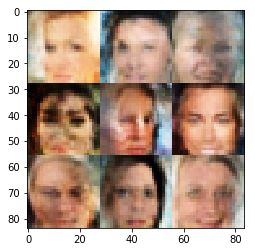

Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 2.1198
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 2.6789
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 2.0888
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 3.3891
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 4.0737
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.9030
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9469
Epoch 1/1.

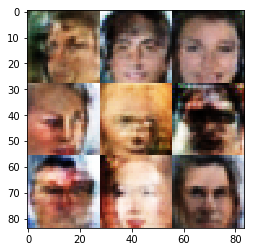

Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 2.5081
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 2.0373
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.7673
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.6814
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 5.1144
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 4.5756
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 3.4342
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.9711
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 3.1830
Epoch 1/1.

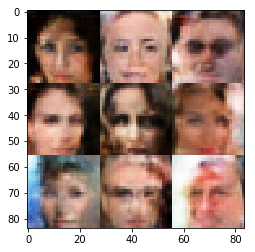

Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.8558
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 3.6134
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.1345
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 2.7046
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 2.9984
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 2.8910
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.1838
Epoch 1/1.

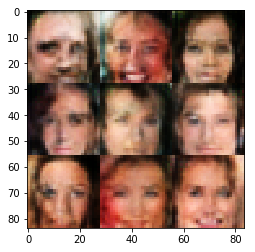

Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.6092
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.9027
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 2.1309
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.7764
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 3.8361
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.1918
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 2.3831
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 1.9576
Epoch 1/1.

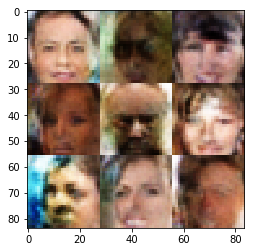

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 3.2894
Epoch 1/1... Discriminator Loss: 1.9140... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 2.4995... Generator Loss: 4.7330
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.4320
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.7690
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 2.5616
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 2.4712
Epoch 1/1.

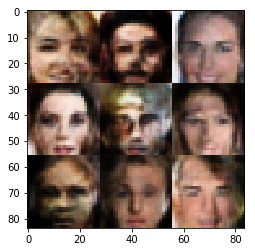

Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.8400
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.6458
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 1.6917
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.3039
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.2607
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.7329
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.2753
Epoch 1/1.

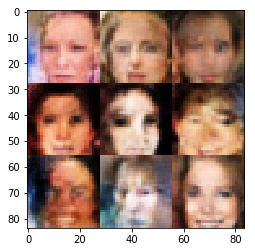

Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.2467
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 3.3372
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 3.3228
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 3.9056
Epoch 1/1... Discriminator Loss: 2.1851... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 2.0494... Generator Loss: 4.3686
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6168
Epoch 1/1.

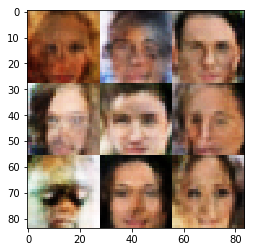

Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.7553
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 2.1988
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 2.8214
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.0429
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 1.8812
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.3821
Epoch 1/1.

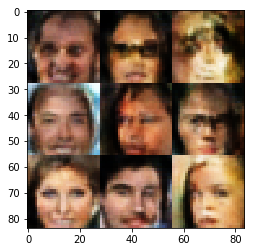

Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 3.0286
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.0388
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.1528
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 2.8340
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 2.8821
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 3.6118
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.7309
Epoch 1/1.

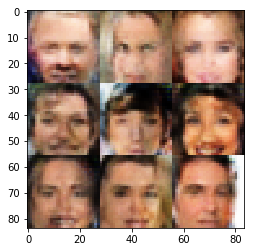

Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 1.6728
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 2.3515
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 5.2880
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 2.6259
Epoch 1/1... Discriminator Loss: 1.6376... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.5628
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5867
Epoch 1/1.

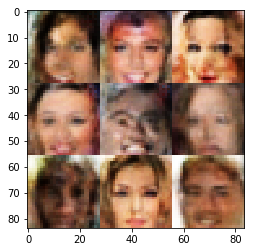

Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 2.6793
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 2.3999
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.3776
Epoch 1/1.

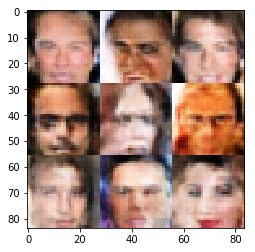

Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 4.2632
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 3.0520
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.6100
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.1376
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.4361
Epoch 1/1.

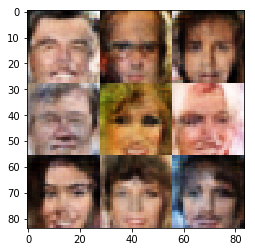

Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.6894
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.2552
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.6779
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.9774
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.7057
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.0429
Epoch 1/1.

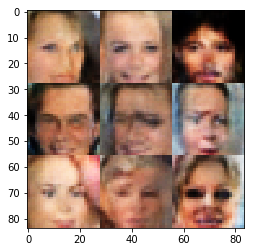

Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.3645
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 3.1645
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.2745
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.8911
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 2.4438
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 2.0237
Epoch 1/1.

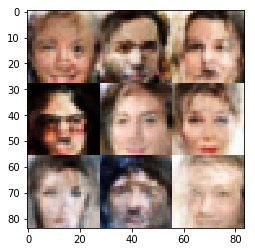

Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.2446
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 2.3595
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.9353
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 2.0803... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 4.4459
Epoch 1/1... Discriminator Loss: 1.9411... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 3.7575
Epoch 1/1.

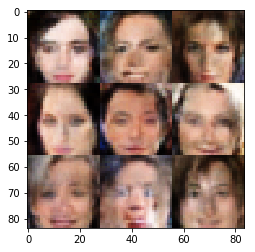

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.4061
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 2.4579
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.1308
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.7703
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 1.9033
Epoch 1/1.

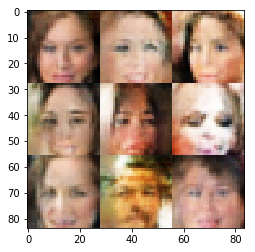

Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 2.9696
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.7545
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.5934
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 2.5652
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.8954
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 2.3423
Epoch 1/1.

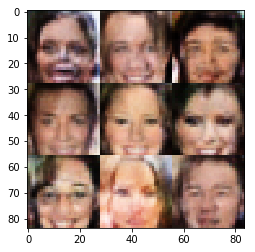

Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.7109
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 2.1394
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.0646
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.7287
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 1.7167
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.0305
Epoch 1/1.

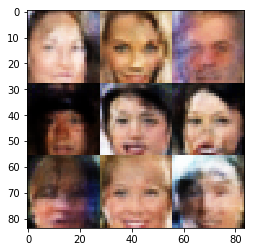

Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.3196
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 2.2102
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.3705
Epoch 1/1.

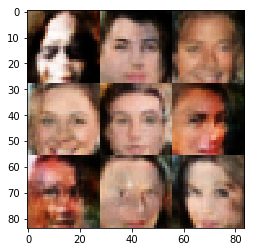

Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 3.2439
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.0840
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.7344
Epoch 1/1.

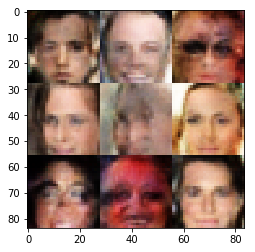

Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.5128
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 1.9955
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.8416
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.2452
Epoch 1/1.

In [25]:

batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。